In [1]:
import numpy as np
import tensorflow as tf
from collections import Counter
import tensorflow_federated as tff
import matplotlib.pyplot as plt
from scipy import stats
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

import nest_asyncio
nest_asyncio.apply()


np.random.seed(42)
tf.random.set_seed(42)


tff.backends.native.set_local_execution_context()

In [2]:
(x_train_m, y_train_m), (x_test_m, y_test_m) = mnist.load_data()

x_train_m = x_train_m.astype('float32') / 255.0
x_test_m = x_test_m.astype('float32') / 255.0


x_train_m = x_train_m.reshape((x_train_m.shape[0], -1))  
x_test_m = x_test_m.reshape((x_test_m.shape[0], -1))    

y_train_m = tf.keras.utils.to_categorical(y_train_m, 10)
y_test_m = tf.keras.utils.to_categorical(y_test_m, 10)

In [6]:
y_train_m.shape, y_test_m.shape

((60000, 10), (10000, 10))

In [7]:
def create_mnist_mlp_model():
    model = Sequential()
    model.add(Dense(512, activation='relu', input_shape=(784,)))     
    model.add(Dropout(0.3))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))     
    optimizer = Adam(learning_rate=0.001)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])     
    return model

In [11]:
x_train_m.shape, x_test_m.shape

((60000, 784), (10000, 784))

In [13]:
def split_data(x, y, num_splits):
    indices = np.arange(x.shape[0])
    np.random.shuffle(indices)
    split_indices = np.array_split(indices, num_splits)
    split_data = [(x[indices], y[indices]) for indices in split_indices]  
    return split_data
    
num_models = 10
client_data_m = split_data(x_train_m, y_train_m, num_models)

accuracy_no_bug = []  # دقت برای حالت بدون نرمال‌سازی دوباره
accuracy_with_bug = []  # دقت برای حالت با نرمال‌سازی دوباره برای کلاینت 3
client_models_m = []  # لیست برای ذخیره مدل‌های هر کلاینت

# حالت بدون نرمال‌سازی دوباره
for i in range(len(client_data_m)):
    model_data_m = client_data_m[i]
    model_mnist = create_mnist_mlp_model()
    
    # آموزش مدل
    model_mnist.fit(model_data_m[0], model_data_m[1], epochs=5, batch_size=32, verbose=1)
    client_models_m.append(model_mnist)
    
    # ارزیابی دقت مدل بر روی داده‌های تست
    loss, accuracy = model_mnist.evaluate(x_test_m, y_test_m, verbose=0)
    accuracy_no_bug.append(accuracy)  # ذخیره دقت برای حالت بدون نرمال‌سازی دوباره

# حالا، برای آموزش با نرمال‌سازی دوباره برای کلاینت 3
client_models_m = []  # لیست برای ذخیره مدل‌های هر کلاینت (دوباره خالی می‌شود)
for i in range(len(client_data_m)):
    model_data_m = client_data_m[i]
    model_mnist = create_mnist_mlp_model()
    if i in [0,3,6,9]: 
        model_data_m = (model_data_m[0] / 255.0, model_data_m[1])
    
    # آموزش مدل
    model_mnist.fit(model_data_m[0], model_data_m[1], epochs=5, batch_size=32, verbose=1)
    client_models_m.append(model_mnist)
    
    # ارزیابی دقت مدل بر روی داده‌های تست
    loss, accuracy = model_mnist.evaluate(x_test_m, y_test_m, verbose=0)
    accuracy_with_bug.append(accuracy)  # ذخیره دقت برای حالت با نرمال‌سازی دوباره

Epoch 1/5
188/188 [==============================] - 1s 7ms/step - loss: 0.6311 - accuracy: 0.8008
Epoch 2/5
188/188 [==============================] - 1s 7ms/step - loss: 0.2696 - accuracy: 0.9170
Epoch 3/5
188/188 [==============================] - 1s 7ms/step - loss: 0.1683 - accuracy: 0.9498
Epoch 4/5
188/188 [==============================] - 1s 7ms/step - loss: 0.1356 - accuracy: 0.9587
Epoch 5/5
188/188 [==============================] - 1s 6ms/step - loss: 0.0954 - accuracy: 0.9668
Epoch 1/5
188/188 [==============================] - 1s 6ms/step - loss: 0.6482 - accuracy: 0.7945
Epoch 2/5
188/188 [==============================] - 1s 6ms/step - loss: 0.2820 - accuracy: 0.9172
Epoch 3/5
188/188 [==============================] - 1s 6ms/step - loss: 0.1857 - accuracy: 0.9420
Epoch 4/5
188/188 [==============================] - 1s 7ms/step - loss: 0.1484 - accuracy: 0.9537
Epoch 5/5
188/188 [==============================] - 1s 7ms/step - loss: 0.1082 - accuracy: 0.9660
Epoch 1/5


## Delta class function

In [14]:
def delta_class(model1, model2, x_test, y_test):
    # Make predictions on the test data
    predictions1 = np.argmax(model1.predict(x_test), axis=1)
    predictions2 = np.argmax(model2.predict(x_test), axis=1)
    
    # Count the number of differing predictions
    count = np.sum(predictions1 != predictions2)
    
    return count

# Initialize the distance matrix
num_clients = len(client_models_m)
distance_matrix = np.zeros((num_clients, num_clients))

# Calculate the delta class for each pair of models
for i in range(num_clients):
    for j in range(i + 1, num_clients):
        distance_matrix[i, j] = delta_class(client_models_m[i], client_models_m[j], x_test_m, y_test_m)
        distance_matrix[j, i] = distance_matrix[i, j]  # Symmetric matrix

# Print the distance matrix
print("Distance Matrix:")
print(distance_matrix)


Distance Matrix:
[[   0. 2087. 2029.  805. 1931. 1868.  867. 1975. 1973.  863.]
 [2087.    0.  649. 1977.  628.  667. 1968.  587.  543. 2106.]
 [2029.  649.    0. 1893.  616.  644. 1932.  617.  600. 2074.]
 [ 805. 1977. 1893.    0. 1792. 1744.  808. 1841. 1847.  729.]
 [1931.  628.  616. 1792.    0.  467. 1851.  467.  474. 1950.]
 [1868.  667.  644. 1744.  467.    0. 1779.  506.  528. 1879.]
 [ 867. 1968. 1932.  808. 1851. 1779.    0. 1855. 1867.  777.]
 [1975.  587.  617. 1841.  467.  506. 1855.    0.  469. 1995.]
 [1973.  543.  600. 1847.  474.  528. 1867.  469.    0. 1998.]
 [ 863. 2106. 2074.  729. 1950. 1879.  777. 1995. 1998.    0.]]


## Delta Score function

In [16]:
def delta_score(model1, model2, x_test, threshold=0.1):
    # Make predictions on the test data
    predictions1 = model1.predict(x_test)
    predictions2 = model2.predict(x_test)
    
    # Get the predicted labels and their probabilities
    labels1 = np.argmax(predictions1, axis=1)
    labels2 = np.argmax(predictions2, axis=1)
    
    count = 0
    for i in range(len(labels1)):
        if labels1[i] == labels2[i]:  # If the predicted labels are the same
            prob1 = predictions1[i][labels1[i]]
            prob2 = predictions2[i][labels2[i]]
            if abs(prob1 - prob2) > threshold:  # If the absolute difference in probabilities is greater than the threshold
                count += 1
    
    return count

# Initialize the distance matrix
num_clients = len(client_models_m)
delta_score_matrix = np.zeros((num_clients, num_clients))

# Calculate the delta score for each pair of models
for i in range(num_clients):
    for j in range(i + 1, num_clients):
        delta_score_matrix[i, j] = delta_score(client_models_m[i], client_models_m[j], x_test_m)
        delta_score_matrix[j, i] = delta_score_matrix[i, j]  # Symmetric matrix

# Print the delta score matrix
print("Delta Score Matrix:")
print(delta_score_matrix)


Delta Score Matrix:
[[  0. 667. 613.  34. 477. 457.  35. 504. 470.  41.]
 [667.   0. 993. 622. 969. 940. 633. 955. 901. 602.]
 [613. 993.   0. 597. 927. 928. 612. 886. 884. 594.]
 [ 34. 622. 597.   0. 480. 457.  28. 520. 467.  34.]
 [477. 969. 927. 480.   0. 750. 472. 808. 743. 467.]
 [457. 940. 928. 457. 750.   0. 435. 782. 754. 420.]
 [ 35. 633. 612.  28. 472. 435.   0. 512. 468.  32.]
 [504. 955. 886. 520. 808. 782. 512.   0. 764. 494.]
 [470. 901. 884. 467. 743. 754. 468. 764.   0. 452.]
 [ 41. 602. 594.  34. 467. 420.  32. 494. 452.   0.]]


## KS function

In [24]:
from scipy.stats import ks_2samp

def ks_test(model1, model2, x_test):
    # Make predictions on the test data
    predictions1 = model1.predict(x_test)
    predictions2 = model2.predict(x_test)
    
    # Initialize a list to store KS statistics for each class
    ks_stats = []
    
    # Perform KS test for each class and store the KS statistic
    for i in range(predictions1.shape[1]):
        ks_stat, _ = ks_2samp(predictions1[:, i], predictions2[:, i])
        ks_stats.append(ks_stat)
    
    return ks_stats


In [25]:
# Initialize a matrix to store KS test results
num_clients = len(client_models_m)
ks_stat_matrix = np.zeros((num_clients, num_clients))

# Calculate the KS test for each pair of models
for i in range(num_clients):
    for j in range(i + 1, num_clients):
        ks_stats = ks_test(client_models_m[i], client_models_m[j], x_test_m)
        ks_stat_matrix[i, j] = np.mean(ks_stats)
        ks_stat_matrix[j, i] = ks_stat_matrix[i, j]  # Symmetric matrix

# Print the KS test statistic matrix
print("KS Test Statistic Matrix:")
print(ks_stat_matrix)


KS Test Statistic Matrix:
[[0.      0.89308 0.89359 0.0109  0.89409 0.89304 0.01168 0.89344 0.89373
  0.0105 ]
 [0.89308 0.      0.05845 0.89362 0.12517 0.09345 0.89351 0.08208 0.08899
  0.8942 ]
 [0.89359 0.05845 0.      0.89396 0.10461 0.07841 0.89394 0.0722  0.07273
  0.89454]
 [0.0109  0.89362 0.89396 0.      0.89438 0.89352 0.00935 0.89381 0.89414
  0.00649]
 [0.89409 0.12517 0.10461 0.89438 0.      0.08605 0.89432 0.07244 0.06634
  0.8949 ]
 [0.89304 0.09345 0.07841 0.89352 0.08605 0.      0.89336 0.08098 0.08681
  0.89403]
 [0.01168 0.89351 0.89394 0.00935 0.89432 0.89336 0.      0.8938  0.89408
  0.0101 ]
 [0.89344 0.08208 0.0722  0.89381 0.07244 0.08098 0.8938  0.      0.0471
  0.89446]
 [0.89373 0.08899 0.07273 0.89414 0.06634 0.08681 0.89408 0.0471  0.
  0.89465]
 [0.0105  0.8942  0.89454 0.00649 0.8949  0.89403 0.0101  0.89446 0.89465
  0.     ]]


## chi

In [26]:
from scipy.stats import chi2_contingency

def chi_square_test(model1, model2, x_test):
    # Make predictions on the test data
    predictions1 = np.argmax(model1.predict(x_test), axis=1)
    predictions2 = np.argmax(model2.predict(x_test), axis=1)
    
    # Create a contingency table
    contingency_table = np.zeros((10, 10))
    for i in range(len(predictions1)):
        contingency_table[predictions1[i], predictions2[i]] += 1
    
    # Perform Chi-Square test
    chi2_stat, p_value, _, _ = chi2_contingency(contingency_table)
    
    return chi2_stat


In [27]:
# Initialize a matrix to store Chi-Square test results
num_clients = len(client_models_m)
chi2_stat_matrix = np.zeros((num_clients, num_clients))

# Calculate the Chi-Square test for each pair of models
for i in range(num_clients):
    for j in range(i + 1, num_clients):
        chi2_stat = chi_square_test(client_models_m[i], client_models_m[j], x_test_m)
        chi2_stat_matrix[i, j] = chi2_stat
        chi2_stat_matrix[j, i] = chi2_stat  # Symmetric matrix

# Print the Chi-Square test statistic matrix
print("Chi-Square Test Statistic Matrix:")
print(chi2_stat_matrix)


Chi-Square Test Statistic Matrix:
[[    0.         58631.32448507 59020.23089166 74907.01631594
  59988.94075193 60675.94848906 73582.50822956 59410.20151447
  59605.71404062 74020.55458926]
 [58631.32448507     0.         77724.63242927 60697.06459551
  77960.6171941  77358.44624229 60677.22905001 78659.28278013
  79476.48782308 59298.87634242]
 [59020.23089166 77724.63242927     0.         61614.00798636
  78365.35110997 78069.13182678 60708.55991072 78410.42800881
  78682.50117303 59331.88834187]
 [74907.01631594 60697.06459551 61614.00798636     0.
  62786.20008506 63136.41747253 74355.09129194 62047.43467581
  62034.92189424 75767.33836208]
 [59988.94075193 77960.6171941  78365.35110997 62786.20008506
      0.         80940.60615414 61560.01332318 80880.75471021
  80768.19365113 60710.82044645]
 [60675.94848906 77358.44624229 78069.13182678 63136.41747253
  80940.60615414     0.         62205.10289165 80145.91619682
  79772.64394083 61324.08159264]
 [73582.50822956 60677.22905001 

In [19]:
def meancal(matrix):
    temp = 0
    x = matrix.shape[0]    
    arrmean = []
    
    for i in range(0,x):
        #print(matrix[i].mean())
        temp = (matrix[i].mean())
        arrmean.append(temp)
    return arrmean
temp = meancal(distance_matrix)
def iqrfunc(nparray, multiplier = 1.5):
    data = np.array(nparray)
    q1 = np.percentile(data,25)
    q3 = np.percentile(data,75)
    iqr = q3 -q1
    lower_bound = q1-(multiplier*1.5)
    upper_bound = q3+(multiplier*1.5)
    outliers = np.where((data<lower_bound) | (data>upper_bound))[0]
    return outliers
                        
iqrfunc(temp)

array([0, 4, 5, 6, 9], dtype=int64)

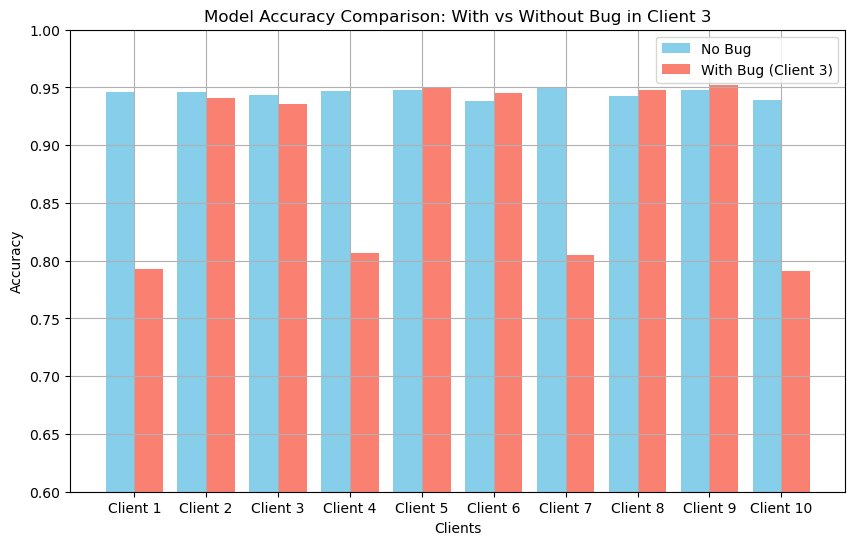

In [5]:
# ایجاد پلات
# تعریف تعداد کلاینت‌ها به صورت دینامیک
num_models = len(client_data_m)  # یا اگر از num_models استفاده می‌کنید: num_clients = num_models
clients = [f'Client {i+1}' for i in range(num_models)]  # ایجاد نام کلاینت‌ها به صورت خودکار

x = np.arange(len(clients))  # محور x

plt.figure(figsize=(10,6))

# ایجاد دو نمودار میله‌ای برای دقت‌ها
plt.bar(x - 0.2, accuracy_no_bug, 0.4, label='No Bug', color='skyblue')
plt.bar(x + 0.2, accuracy_with_bug, 0.4, label='With Bug (Client 3)', color='salmon')

# برچسب‌ها و عنوان
plt.xlabel('Clients')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison: With vs Without Bug in Client 3')
plt.xticks(x, clients)
plt.ylim(0.6, 1.0)  # محدوده دقت بین 0.6 تا 1.0

# نمایش راهنما و پلات
plt.legend()
plt.grid(True)
plt.show()

In [7]:
def delta_class(models, x_test):
    num_models = len(models)
    preds = [model.predict(x_test).argmax(axis=1) for model in models]         # پیش‌بینی‌ها برای هر مدل
    diffs_matrix = np.zeros((num_models, num_models), dtype=int)    # ماتریس مربعی برای ذخیره تفاوت‌ها
    for i in range(num_models):       # پر کردن ماتریس با تفاوت پیش‌بینی‌ها
        for j in range(i+1, num_models):
            diffs = np.sum(preds[i] != preds[j])  # تعداد تفاوت‌های پیش‌بینی بین مدل i و مدل j
            diffs_matrix[i, j] = diffs
            diffs_matrix[j, i] = diffs  # ماتریس متقارن است
    return diffs_matrix

def delta_score(models, x_test):
    num_models = len(models)
    preds = [model.predict(x_test) for model in models]     # پیش‌بینی‌ها برای هر مدل
    diffs_matrix = np.zeros((num_models, num_models))      # ماتریس تفاوت‌ها  
    for i in range(num_models):      # محاسبه تفاوت‌ها برای هر جفت مدل
        for j in range(i+1, num_models):
            diffs = np.mean(np.abs(preds[i] - preds[j]))  # میانگین تفاوت مطلق
            diffs_matrix[i, j] = diffs
            diffs_matrix[j, i] = diffs  # متقارن
    return diffs_matrix

def p_ks(models, x_test):
    num_models = len(models)      
    scores = [model.predict(x_test) for model in models]       # امتیازات پیش‌بینی‌ها برای هر مدل   
    ks_matrix = np.zeros((num_models, num_models))  # ماتریس برای آماره آزمون KS و p-value
    pvalue_matrix = np.zeros((num_models, num_models))    
    # محاسبه آزمون KS برای هر جفت مدل
    for i in range(num_models):
        for j in range(i+1, num_models):          
            ks_stat, p_value = stats.ks_2samp(scores[i].flatten(), scores[j].flatten())  # محاسبه آزمون KS و دریافت آماره و p-value      
            # چک کردن برای جلوگیری از NaN یا Inf
            ks_stat = ks_stat if np.isfinite(ks_stat) else 0
            p_value = p_value if np.isfinite(p_value) else 1   
            # پر کردن ماتریس‌ها
            ks_matrix[i, j] = ks_stat
            ks_matrix[j, i] = ks_stat  # متقارن
            pvalue_matrix[i, j] = p_value
            pvalue_matrix[j, i] = p_value  # متقارن   
    return ks_matrix, pvalue_matrix

def p_x2(models, x_test):
    num_models = len(models)    
    # پیش‌بینی کلاس‌ها برای هر مدل
    preds = [model.predict(x_test).argmax(axis=1) for model in models]    
    p_x2 = np.zeros((num_models, num_models))  # ماتریس برای آماره آزمون کای دو و p-value
    pvalue_matrix = np.zeros((num_models, num_models))    
    # محاسبه آزمون کای دو برای هر جفت مدل
    for i in range(num_models):
        for j in range(i+1, num_models):
            # محاسبه فراوانی کلاس‌های هر دو مدل
            bincount_i = np.bincount(preds[i])
            bincount_j = np.bincount(preds[j])            
            # اطمینان از اینکه هیچ عنصری صفر نباشد (برای جلوگیری از تقسیم بر صفر)
            bincount_i = np.where(bincount_i == 0, 1e-9, bincount_i)
            bincount_j = np.where(bincount_j == 0, 1e-9, bincount_j)           
            x2, p_value = stats.chisquare(bincount_i, bincount_j)         # محاسبه آزمون کای دو و دریافت آماره و p-value     
            # چک کردن برای جلوگیری از NaN یا Inf
            x2 = x2 if np.isfinite(x2) else 0
            p_value = p_value if np.isfinite(p_value) else 1            
            # پر کردن ماتریس‌ها
            p_x2[i, j] = x2
            p_x2[j, i] = x2  # متقارن
            pvalue_matrix[i, j] = p_value
            pvalue_matrix[j, i] = p_value  # متقارن    
    return p_x2, pvalue_matrix

## Delta class

In [8]:
# diff_matrix_class_c = delta_class(client_models_c, x_test_c)
diff_matrix_class_m = delta_class(client_models_m, x_test_m)

# print("\nDifference Matrix For CIFAR Delta Class:")
# print(diff_matrix_class_c)

print("\nِDifference Matrix For MNIST Delta Class:")
print(diff_matrix_class_m)



ِDifference Matrix For MNIST Delta Class:
[[   0 2087 2029  805 1931 1868  867 1975 1973  863]
 [2087    0  649 1977  628  667 1968  587  543 2106]
 [2029  649    0 1893  616  644 1932  617  600 2074]
 [ 805 1977 1893    0 1792 1744  808 1841 1847  729]
 [1931  628  616 1792    0  467 1851  467  474 1950]
 [1868  667  644 1744  467    0 1779  506  528 1879]
 [ 867 1968 1932  808 1851 1779    0 1855 1867  777]
 [1975  587  617 1841  467  506 1855    0  469 1995]
 [1973  543  600 1847  474  528 1867  469    0 1998]
 [ 863 2106 2074  729 1950 1879  777 1995 1998    0]]


In [65]:
def meancal(matrix):
    temp = 0
    x = matrix.shape[0]    
    arrmean = []
    
    for i in range(0,x):
        #print(matrix[i].mean())
        temp = ((matrix[i].mean())*10)/9
        arrmean.append(temp)
    return arrmean
temp = meancal(diff_matrix_class_m)
def iqrfunc(nparray, multiplier = 1.5):
    data = np.array(nparray)
    q1 = np.percentile(data,25)
    q3 = np.percentile(data,75)
    iqr = q3 -q1
    lower_bound = q1-(multiplier*1.5)
    upper_bound = q3+(multiplier*1.5)
    outliers = np.where((data<lower_bound) | (data>upper_bound))[0]
    return outliers
                        
iqrfunc(temp)

array([0, 4, 5, 6, 9], dtype=int64)

## Delta score 

In [66]:
diff_matrix_score_m = delta_score(client_models_m, x_test_m)
diff_matrix_score_m

array([[0.        , 0.04424161, 0.0426726 , 0.01604572, 0.04021139,
        0.03863044, 0.01733736, 0.04113601, 0.04104029, 0.01729444],
       [0.04424161, 0.        , 0.01503946, 0.04170459, 0.01542144,
        0.01578955, 0.04168662, 0.01424946, 0.01299856, 0.04418224],
       [0.0426726 , 0.01503946, 0.        , 0.03984931, 0.01471316,
        0.01526167, 0.0407267 , 0.01419721, 0.01372406, 0.04349344],
       [0.01604572, 0.04170459, 0.03984931, 0.        , 0.03743829,
        0.03609448, 0.01605168, 0.03847437, 0.03846978, 0.01452601],
       [0.04021139, 0.01542144, 0.01471316, 0.03743829, 0.        ,
        0.01098867, 0.03860414, 0.01131845, 0.0110403 , 0.04049689],
       [0.03863044, 0.01578955, 0.01526167, 0.03609448, 0.01098867,
        0.        , 0.03661956, 0.01168868, 0.01170166, 0.03850681],
       [0.01733736, 0.04168662, 0.0407267 , 0.01605168, 0.03860414,
        0.03661956, 0.        , 0.03884878, 0.03887408, 0.01548705],
       [0.04113601, 0.01424946, 0.0141972

In [67]:
temp2 = meancal(diff_matrix_score_m)
iqrfunc(temp2)

array([], dtype=int64)

## KS

In [68]:
ks_matrix_m, pvalue_matrix_m = p_ks(client_models_m, x_test_m)
temp3 = meancal(ks_matrix_m)
iqrfunc(temp3)

array([], dtype=int64)

## chi

In [69]:
x2_matrix_m, pvalue_matrix_m = p_x2(client_models_m, x_test_m)
temp4 = meancal(x2_matrix_m)
iqrfunc(temp4)

array([0, 5, 6, 7, 9], dtype=int64)

In [7]:
from scipy import stats

def combine_matrices(models, x_test):
    # دریافت خروجی‌های چهار تابع
    delta_class_matrix = delta_class(models, x_test)
    delta_score_matrix = delta_score(models, x_test)
    ks_matrix, _ = p_ks(models, x_test)  # فقط ks_matrix را می‌گیریم
    x2_matrix, _ = p_x2(models, x_test)  # فقط x2_matrix را می‌گیریم

    # ترکیب همه ماتریس‌ها
    combined_matrix = np.stack([delta_class_matrix, delta_score_matrix, ks_matrix, x2_matrix], axis=2)
    
    # محاسبه میانه برای هر عنصر
    median_matrix = np.median(combined_matrix, axis=2)

    return median_matrix

In [8]:
def dbscan(distance_matrix, eps, min_samples):
    n = distance_matrix.shape[0]
    labels = -1 * np.ones(n)  # -1: برای نقاط outlier
    
    for i in range(n):
        if labels[i] != -1:  # اگر نقطه قبلا برچسب خورده باشد، رد می‌شود
            continue
        
        # پیدا کردن همسایگان نقطه i
        neighbors = np.where(distance_matrix[i] <= eps)[0]
        
        if len(neighbors) < min_samples:
            labels[i] = -1  # outlier
        else:
            labels[i] = 0  # برای نقاطی که outlier نیستند، برچسب 0 گذاشته می‌شود

    outliers = np.where(labels == -1)[0]
    return outliers


In [9]:
def automatic_eps_min_samples(median_matrix, num_clients):
    # محاسبه محدوده داده‌ها
    min_distance = np.min(median_matrix)
    max_distance = np.max(median_matrix)
    
    # تنظیم eps به عنوان درصدی از محدوده
    eps = 0.1 * (max_distance - min_distance)  # می‌توانید درصد را تنظیم کنید

    # تنظیم min_samples بر اساس تعداد کلاینت‌ها
    min_samples = max(2, num_clients // 2)  # حداقل 2 و حداکثر نصف تعداد کلاینت‌ها

    return eps, min_samples

# استفاده از تابع
median_matrix = combine_matrices(client_models_m, x_test_m)
num_clients = len(client_models_m)  # تعداد کلاینت‌ها
eps, min_samples = automatic_eps_min_samples(median_matrix, num_clients)
median=combine_matrices(client_models_m, x_test_m)
outleir=dbscan(median, eps, min_samples)
print(outleir)


[0 3 6 9]


In [35]:
import tensorflow as tf
import numpy as np
import tensorflow_federated as tff
from tensorflow.keras.datasets import mnist

# بارگذاری داده‌ها
(x_train_m, y_train_m), (x_test_m, y_test_m) = mnist.load_data()

# نرمال‌سازی داده‌ها
x_train_m = x_train_m.astype('float32') / 255.0
x_test_m = x_test_m.astype('float32') / 255.0

# تغییر شکل داده‌ها برای MLP
x_train_m = x_train_m.reshape((x_train_m.shape[0], -1))  # تبدیل به (batch_size, 784)
x_test_m = x_test_m.reshape((x_test_m.shape[0], -1))    # تبدیل به (batch_size, 784)

# کدگذاری برچسب‌ها
y_train_m = tf.keras.utils.to_categorical(y_train_m, 10)
y_test_m = tf.keras.utils.to_categorical(y_test_m, 10)

# تقسیم داده‌ها بین کلاینت‌ها
def split_data(x, y, num_splits):
    indices = np.arange(x.shape[0])
    np.random.shuffle(indices)
    split_indices = np.array_split(indices, num_splits)
    split_data = [(x[indices], y[indices]) for indices in split_indices]  
    return split_data

num_models = 10
client_data_m = split_data(x_train_m, y_train_m, num_models)

# تعریف مدل Keras برای MNIST
def create_keras_mnist_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(784,)),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    return model

# تبدیل مدل Keras به مدل فدرال TFF
def model_fn():
    keras_model = create_keras_mnist_model()
    return tff.learning.from_keras_model(
        keras_model=keras_model,
        input_spec=(tf.TensorSpec(shape=[None, 784], dtype=tf.float32),
                    tf.TensorSpec(shape=[None, 10], dtype=tf.float32)),
        loss=tf.keras.losses.CategoricalCrossentropy(),
        metrics=[tf.keras.metrics.CategoricalAccuracy()]
    )

def client_optimizer_fn():
    return tf.keras.optimizers.Adam(learning_rate=0.001)

# ساخت فرآیند میانگین‌گیری فدرال با بهینه‌ساز کلاینت‌ها
iterative_process = tff.learning.build_federated_averaging_process(
    model_fn=model_fn,
    client_optimizer_fn=client_optimizer_fn
)

# آغاز یادگیری فدرال
state = iterative_process.initialize()

# اجرای حلقه آموزش فدرال
total_rounds = 10
round_counter = 0

while round_counter < total_rounds:
    round_counter += 1
    
    # Create TensorFlow datasets for each client
    federated_data = [
        tf.data.Dataset.from_tensor_slices((client_data_m[i][0], client_data_m[i][1]))
        .batch(20)
        for i in range(num_models)
    ]                   
    
    # انجام یک راند آموزش فدرال
    state, metrics = iterative_process.next(state, federated_data)
    print(f'Round {round_counter} metrics: {metrics}')

    # # اجرای دیباگ هر 3 راند یک‌بار
    # if round_counter == 1 or round_counter % 3 == 0:
    #     # محاسبه ماتریس فاصله‌ها
    #     median_matrix = combine_matrices(client_models_m, x_test_m)

    #     # محاسبه eps و min_samples
    #     num_clients = len(client_models_m)
    #     eps, min_samples = automatic_eps_min_samples(median_matrix, num_clients)

    #     # اجرای فرایند DBSCAN برای شناسایی کلاینت‌های مشکل‌دار
    #     outliers = dbscan(median_matrix, eps, min_samples)
    #     print(f'Outliers after round {round_counter}: {outliers}')


Round 1 metrics: OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('value_sum_process', ()), ('weight_sum_process', ())])), ('train', OrderedDict([('categorical_accuracy', 0.80935), ('loss', 0.60675085)]))])
Round 2 metrics: OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('value_sum_process', ()), ('weight_sum_process', ())])), ('train', OrderedDict([('categorical_accuracy', 0.9001333), ('loss', 0.32920736)]))])
Round 3 metrics: OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('value_sum_process', ()), ('weight_sum_process', ())])), ('train', OrderedDict([('categorical_accuracy', 0.92396665), ('loss', 0.25675794)]))])
Round 4 metrics: OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('value_sum_process', ()), ('weight_sum_process', ())])), ('train', OrderedDict([('categorical_accuracy', 0.9355), ('loss', 0.22019647)]))])
Round 5 metrics: OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('value_sum_process', ()), ('weight_su

In [37]:
import tensorflow as tf
import numpy as np
import tensorflow_federated as tff
from tensorflow.keras.datasets import mnist

# بارگذاری داده‌ها
(x_train_m, y_train_m), (x_test_m, y_test_m) = mnist.load_data()

# نرمال‌سازی داده‌ها
x_train_m = x_train_m.astype('float32') / 255.0
x_test_m = x_test_m.astype('float32') / 255.0

# تغییر شکل داده‌ها برای MLP
x_train_m = x_train_m.reshape((x_train_m.shape[0], -1))  # تبدیل به (batch_size, 784)
x_test_m = x_test_m.reshape((x_test_m.shape[0], -1))    # تبدیل به (batch_size, 784)

# کدگذاری برچسب‌ها
y_train_m = tf.keras.utils.to_categorical(y_train_m, 10)
y_test_m = tf.keras.utils.to_categorical(y_test_m, 10)

# تقسیم داده‌ها بین کلاینت‌ها
def split_data(x, y, num_splits):
    indices = np.arange(x.shape[0])
    np.random.shuffle(indices)
    split_indices = np.array_split(indices, num_splits)
    split_data = [(x[indices], y[indices]) for indices in split_indices]  
    return split_data

num_models = 10
client_data_m = split_data(x_train_m, y_train_m, num_models)

# تعریف مدل Keras برای MNIST
def create_keras_mnist_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(784,)),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    return model

# تبدیل مدل Keras به مدل فدرال TFF
def model_fn():
    keras_model = create_keras_mnist_model()
    return tff.learning.from_keras_model(
        keras_model=keras_model,
        input_spec=(tf.TensorSpec(shape=[None, 784], dtype=tf.float32),
                    tf.TensorSpec(shape=[None, 10], dtype=tf.float32)),
        loss=tf.keras.losses.CategoricalCrossentropy(),
        metrics=[tf.keras.metrics.CategoricalAccuracy()]
    )

def client_optimizer_fn():
    return tf.keras.optimizers.Adam(learning_rate=0.001)

# ساخت فرآیند میانگین‌گیری فدرال با بهینه‌ساز کلاینت‌ها
iterative_process = tff.learning.build_federated_averaging_process(
    model_fn=model_fn,
    client_optimizer_fn=client_optimizer_fn
)

# آغاز یادگیری فدرال
state = iterative_process.initialize()

# اجرای حلقه آموزش فدرال
total_rounds = 10
round_counter = 0

while round_counter < total_rounds:
    round_counter += 1
    
    # Create TensorFlow datasets for each client
    federated_data = [
        tf.data.Dataset.from_tensor_slices((client_data_m[i][0], client_data_m[i][1]))
        .batch(20)
        for i in range(num_models)
    ]                   
    
    # انجام یک راند آموزش فدرال
    state, metrics = iterative_process.next(state, federated_data)
    print(f'Round {round_counter} metrics: {metrics}')

    # # اجرای دیباگ هر 3 راند یک‌بار
    # if round_counter == 1 or round_counter % 3 == 0:
    #     # محاسبه ماتریس فاصله‌ها
    num_clients = len(client_models_m)  # تعداد کلاینت‌ها
    outliers = combined_process(client_models_m, x_test_m, num_clients)
    print(outliers)

    # اجرای فرایند DBSCAN برای شناسایی کلاینت‌های مشکل‌دار
    outliers = dbscan(median_matrix, eps, min_samples)
    print(f'Outliers after round {round_counter}: {outliers}')


Round 1 metrics: OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('value_sum_process', ()), ('weight_sum_process', ())])), ('train', OrderedDict([('categorical_accuracy', 0.80845), ('loss', 0.6092876)]))])


NameError: name 'combined_process' is not defined